In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.examples.utils import getSampleObj
from sopt.optimizers.tensorflow import Curveball
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph
from tensorflow.python.framework import graph_util

In [2]:
%load_ext autoreload
%autoreload 2

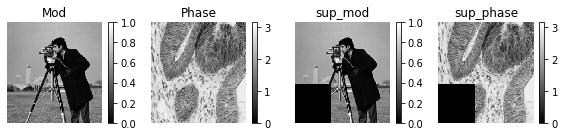

In [3]:
image = getSampleObj(256, phase_range=np.pi)
ft_mod = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(image), norm='ortho')))

var_shape = 100
sample_support = image.copy()
sample_support[:var_shape, :var_shape] = 0

plt.figure(figsize=[8,2])
figs = { 'Mod':np.abs(image), 'Phase':np.angle(image), 
        'sup_mod':np.abs(sample_support), 'sup_phase': np.angle(sample_support)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,4,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.colorbar()
    plt.title(key)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
init_weights = np.ones(2 * var_shape * var_shape)
support_shape = sample_support.shape[0]
var_shape, support_shape

(100, 256)

In [14]:
tf.reset_default_graph()
with tf.name_scope("initialize"):
    tf_var = tf.get_variable('var', dtype=tf.float32, shape=[2 * var_shape**2], initializer=tf.ones_initializer)
    tf_support = tf.constant(sample_support, dtype=tf.complex64, name='support')
    tf_diffraction_mod = tf.constant(np.fft.fftshift(ft_mod).flatten(), dtype=tf.float32, name='diffractions')

def get_var_and_support(var):
    tf_var_reshaped = tf.reshape(var, [2, var_shape, var_shape])
    tf_var_cmplx = tf.complex(tf_var_reshaped[0], tf_var_reshaped[1])
    tf_var_padded = tf.pad(tf_var_cmplx, [[0,support_shape - var_shape], [0, support_shape - var_shape]])
    tf_var_and_support = tf_var_padded + tf_support
    return tf_var_and_support

def predictions_fn(var):
    with tf.name_scope("predictions"):
        tf_var_and_support = get_var_and_support(var)
        fft_step = tf.fft2d(tf_var_and_support, name='fft_step')
        tf_fft_mod = tf.abs(fft_step) / support_shape
    return tf.reshape(tf_fft_mod, [-1])

def loss_fn(predictions):
    with tf.name_scope("loss"):
        loss = 0.5 * tf.reduce_sum((predictions - tf_diffraction_mod)**2)
    return loss


predictions_tensor = predictions_fn(tf_var)
loss_fn_tensor = loss_fn(predictions_tensor)

predictions_tensor_identity = tf.identity(predictions_tensor, name='predictions_tensor')
loss_fn_tensor_identity = tf.identity(loss_fn_tensor, name='loss_tensor')

cb_opt = Curveball(tf_var, predictions_fn, loss_fn, name='opt1', hessian_fn=lambda x: 1.0)
min_op = cb_opt.minimize()
min_op_identity = tf.identity(min_op, name='minimize_op')

session = tf.Session()
session.run(tf.global_variables_initializer())

In [15]:
g = tf.get_default_graph()
graph_def = g.as_graph_def()
g.finalize()

In [16]:
run_meta = tf.RunMetadata()
opts = tf.profiler.ProfileOptionBuilder.float_operation()    
flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
print(flops_cb_and_fwd)

55809057


In [17]:
sub_graph_fwd = graph_util.extract_sub_graph(graph_def, ['loss_tensor'])
sub_graph_cb = graph_util.extract_sub_graph(graph_def, ['minimize_op'])

In [18]:
total_fwd_flops = get_flops_for_sub_graph(g, sub_graph_fwd)
total_cb_flops = get_flops_for_sub_graph(g, sub_graph_cb)

# This should be almost the same as the number I get if I comment out the 
# predictions_tensor and loss_fn_tensor calculatiosn
total_cb_flops_correct = flops_cb_and_fwd - total_fwd_flops

total_fwd_flops, total_cb_flops, total_cb_flops_correct


    For gradient calculations, I don't think the number generated here 
    reflects the true cost of the grad calculation.
    This gives a lower number than what I think should be the actual cost.
    

    For gradient calculations, I don't think the number generated here 
    reflects the true cost of the grad calculation.
    This gives a lower number than what I think should be the actual cost.
    


(6029312, 38684169, 49779745)

In [19]:
session.run(loss_fn_tensor)

3714.0376

In [20]:
%%time
# Count number of flops required to reach loss < 1e-2
count_outer = 0
while True:
    count_outer += 1
    _ = session.run(min_op)
    lossval = session.run(loss_fn_tensor)
    if count_outer % 10 == 0: print(lossval)
    if lossval < 1e-2: break
total_iters = session.run(cb_opt._iteration)
total_iters, count_outer

49.254784
1.066127
0.019436382
CPU times: user 458 ms, sys: 126 ms, total: 584 ms
Wall time: 500 ms


(32, 32)

In [21]:
total_flops = count_outer * total_cb_flops_correct
total_flops

1592951840